# Load libraries

In [1]:
!git clone https://github.com/koshian2/OctConv-TFKeras
!mv OctConv-TFKeras/*.py ./

fatal: destination path 'OctConv-TFKeras' already exists and is not an empty directory.
mv: cannot stat 'OctConv-TFKeras/*.py': No such file or directory


In [1]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 316kB/s 
     |████████████████████████████████| 3.2MB 33.5MB/s 
     |████████████████████████████████| 368kB 34.8MB/s 
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, History, ModelCheckpoint
from tensorflow.contrib.tpu.python.tpu import keras_support
from models import *

from keras.datasets import cifar10
from keras.utils import to_categorical
import pickle, os, time
import matplotlib.pyplot as plt

from utils import extract_features

In [0]:
train_dir = 'dogs_32/train/'
validation_dir = 'dogs_32/validation/'
test_dir = 'dogs_32/test/'

STD_SIZE = (32, 32)
BATCH_SIZE = 20
ENVIRONNEMENT = 'colab'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

In [0]:
def lr_scheduler(epoch):
    x = 0.1
    if epoch >= 100: x /= 5.0
    if epoch >= 150: x /= 5.0
    if epoch >= 200: x /= 5.0
    return x

# 2 breeds

In [6]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 202 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 37 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (37, 32, 32, 3)


In [7]:
alpha = 0.25
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#train_gen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, 
#                                width_shift_range=4.0/32.0, height_shift_range=4.0/32.0)
#test_gen = ImageDataGenerator(rescale=1.0/255)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

tf.logging.set_verbosity(tf.logging.FATAL)

if alpha <= 0:
    model = create_normal_wide_resnet_binary()
else:
    model = create_octconv_wide_resnet_binary(alpha)
model.compile(SGD(0.1, momentum=0.9), "binary_crossentropy", ["acc"])
model.summary()
"""
# convert to tpu model
tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
strategy = keras_support.TPUDistributionStrategy(tpu_cluster_resolver)
model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)
"""
scheduler = LearningRateScheduler(lr_scheduler)
hist = History()
model_checkpoint = ModelCheckpoint(PATH + 'wrn_dogs_2', monitor='val_acc', save_best_only=True, verbose=0)

start_time = time.time()
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.n // BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.n // BATCH_SIZE,
                    callbacks=[scheduler, hist, model_checkpoint], epochs=200)
elapsed = time.time() - start_time
print(elapsed)

history = hist.history
history["elapsed"] = elapsed

with open(PATH + f"wrn_dogs_2_alpha_{alpha}.pkl", "wb") as fp:
    pickle.dump(history, fp)

model = load_model(PATH + 'wrn_dogs_2')
print(model.evaluate(test_features, test_labels))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 16, 16, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
oct_conv2d (OctConv2D)          [(None, 32, 32, 12), 864         input_1[0][0]                    
                                                                 average_pooling2d[0][0]          
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 12)   48          oct_conv2d[0][0]                 
__________

KeyboardInterrupt: ignored

# Results

For alpha = 0:
 Max test accuracy = 0.9104

For alpha = 0.125:
 Max test accuracy = 0.9104



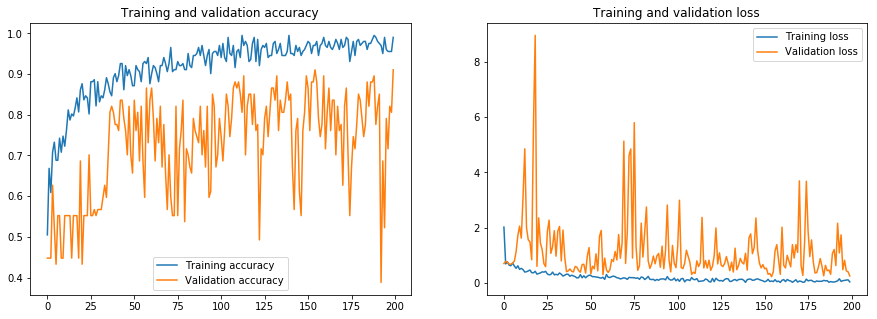

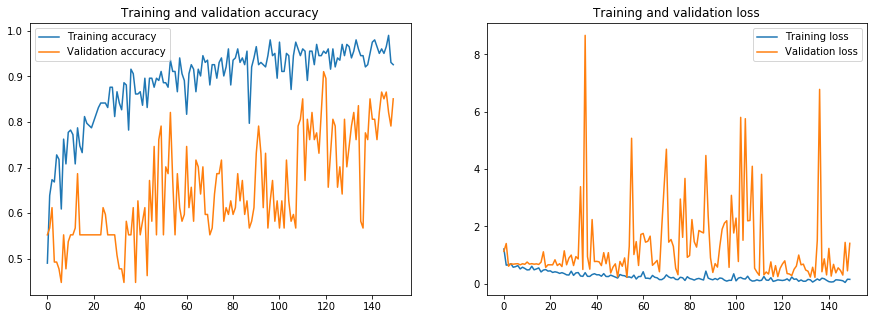

In [6]:
for alpha in [0, 0.125]:
    with open(f"results/wrn_dogs_alpha_{alpha}_history", "rb") as fp:
        data = pickle.load(fp)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(data['val_acc']):.04}\n")
        
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(data["acc"], label="Training accuracy")
    axs[0].plot(data["val_acc"], label="Validation accuracy")
    axs[0].set_title("Training and validation accuracy")
    axs[0].legend()

    axs[1].plot(data["loss"], label="Training loss")
    axs[1].plot(data["val_loss"], label="Validation loss")
    axs[1].set_title("Training and validation loss")
    axs[1].legend()

plt.show()